# Análisis de Series Temporales
#### Primer trabajo práctico
---
**Alumnos:** Novaresse, Pagani, Edgar  
**Fecha:** 23 de Junio de 2025  
**Descripción:** Forecast en variables macroeconómicas

#### 1. Introducción
Este trabajo práctico analiza la serie temporal del **Estimador Mensual de Actividad Económica (EMAE)**, índice base 2004, con datos mensuales desde enero de 2004 hasta marzo de 2025. El objetivo es modelar la serie usando AR, MA, ARMA, ARIMA, SARIMA y SARIMAX, comparando su desempeño con métricas como AIC, BIC, MSE, MAE y RMSE, y generar pronósticos a 12 meses (hasta marzo 2026). Se incluirá una variable dummy para la crisis de COVID-19 (marzo-diciembre 2020) como variable exógena para proponer un modelo SARIMAX. 

#### 2. Importar librerías necesarias

In [1]:
# Creo un environment que tenga las versiones compatibles de Numpy y PMDarima
!conda create -y -n ts_env \
    -c conda-forge \
    python=3.11 \
    numpy=1.24.4 \
    pandas \
    matplotlib \
    seaborn \
    statsmodels \
    scipy \
    pmdarima \
    scikit-learn \
    ipykernel

!conda run -n ts_env python -m ipykernel install --user --name ts_env --display-name "Python (ts_env)"


CondaValueError: prefix already exists: C:\Users\Usuario30\AppData\Local\r-miniconda\envs\ts_env


DirectoryNotACondaEnvironmentError: The target directory exists, but it is not a conda environment.
Use 'conda create' to convert the directory to a conda environment.
  target directory: C:\Users\Usuario30\AppData\Local\r-miniconda\envs\ts_env




In [2]:
# Cargamos librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy.stats import jarque_bera, shapiro, probplot, boxcox
from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import timedelta
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

----
## 3. Carga y exploración de los datos

In [3]:
# Cargamos los datos
df_emae = pd.read_csv('emae-valores-anuales-indice-base-2004-mensual.csv', parse_dates=['indice_tiempo'])
df_emae.set_index('indice_tiempo', inplace=True) # impongo como índice las fechas
df_emae.index.freq = 'MS' # la frecuencia del índice es mensual
df_emae = df_emae[['emae_original']] # me quedo únicamente con la columna emae_original
df_emae.head()

,emae_original
indice_tiempo,
2004-01-01,92.627506
2004-02-01,90.186179
2004-03-01,101.883298
2004-04-01,102.567430
2004-05-01,109.877504


In [4]:
# Verificamos que el indice sea del tipo DatetimeIndex
print(df_emae.index)

# OK! datetime, y frecuencia mensual

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01',
               '2025-02-01', '2025-03-01'],
              dtype='datetime64[ns]', name='indice_tiempo', length=255, freq='MS')


In [5]:
# Verificamos la existencia de valores nulos
print("Valores faltantes:")
print(df_emae.isnull().values.any())

Valores faltantes:
False


In [6]:
# Estadísticas descriptivas
print("Estadísticas Descriptivas:")
print(df_emae.describe())

Estadísticas Descriptivas:
       emae_original
count     255.000000
mean      137.347227
std        15.799563
min        90.186179
25%       128.935784
50%       141.276935
75%       147.256058
max       168.886101


#### Visualización y descomposición de la serie 

In [7]:
# Función para graficar
def graficar(serie, titulo='', xlabel='', ylabel='', figsize=(10, 3), usar_leyenda=False, label=''):
    plt.figure(figsize=figsize)
    if usar_leyenda:
        plt.plot(serie, label=label)
        plt.legend()
    else:
        plt.plot(serie)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

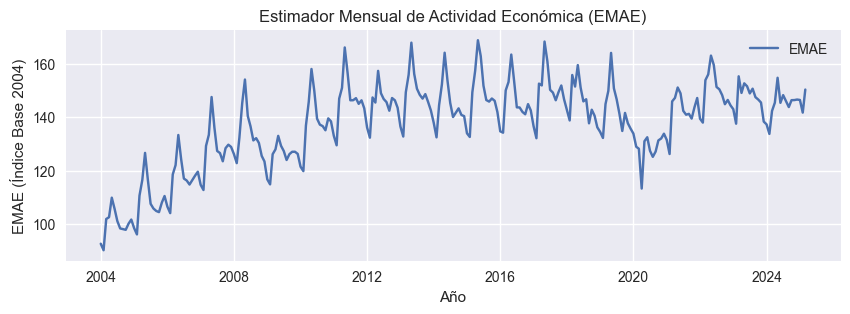

In [8]:
# Visualizamos nuestros datos
graficar(df_emae['emae_original'], titulo='Estimador Mensual de Actividad Económica (EMAE)',
         xlabel='Año', ylabel='EMAE (Índice Base 2004)', figsize=(10, 3),
         usar_leyenda=True, label='EMAE')

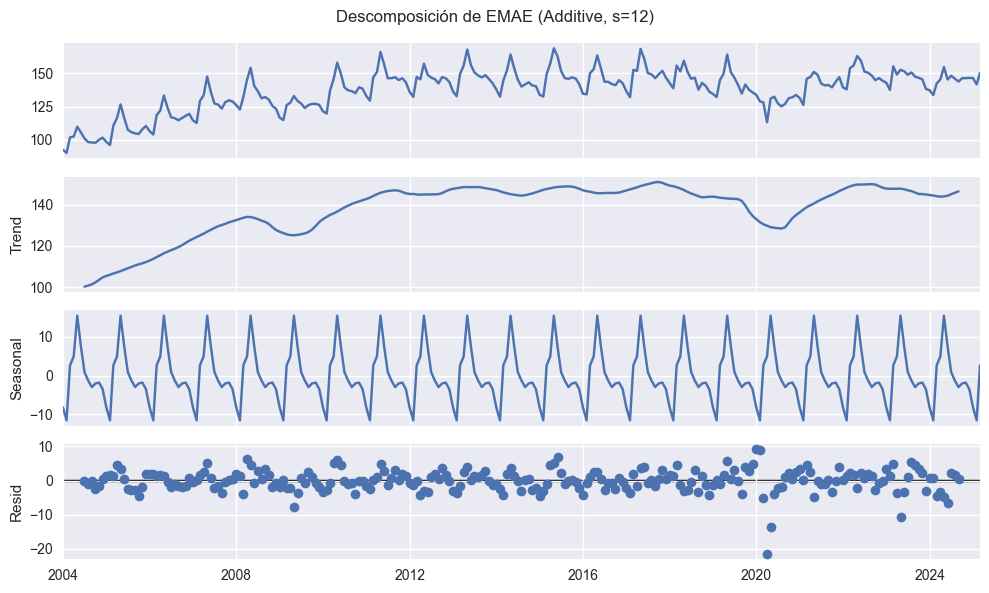

In [9]:
# Descomposición de la serie en diferentes componentes
decomp = seasonal_decompose(df_emae, model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(10, 6)
plt.suptitle('Descomposición de EMAE (Additive, s=12)')
plt.tight_layout()
plt.show()

----
## 4. Análisis de estacionariedad

#### ACF, PACF, Autocovarianzas 

In [10]:
# Función para graficar ACF, PACF, autocovarianzas
# Fue construida a partir de la función utilizada en un notebook del profesor, y con ChatGPT se le pidió que la reformule para que sea aplicable a una
# serie, y no dos. 
def graficar_acf_pacf_autocov(serie, n_lags=50, titulo="Análisis de correlación temporal"):
    fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)

    fig.suptitle(titulo, fontsize=12)

    # ACF
    plot_acf(serie, lags=n_lags, ax=axes[0], color='blue', 
             vlines_kwargs={"colors": 'blue'}, title="Autocorrelación (ACF)")

    # PACF
    plot_pacf(serie, lags=n_lags, ax=axes[1], color='green', 
              vlines_kwargs={"colors": 'green'}, method='ywm', title="Autocorrelación Parcial (PACF)")

    # Autocovarianzas
    autocov = tsa.acovf(serie, fft=False, nlag=n_lags)
    axes[2].plot(autocov, color='red')
    axes[2].set_title("Autocovarianzas")
    axes[2].set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

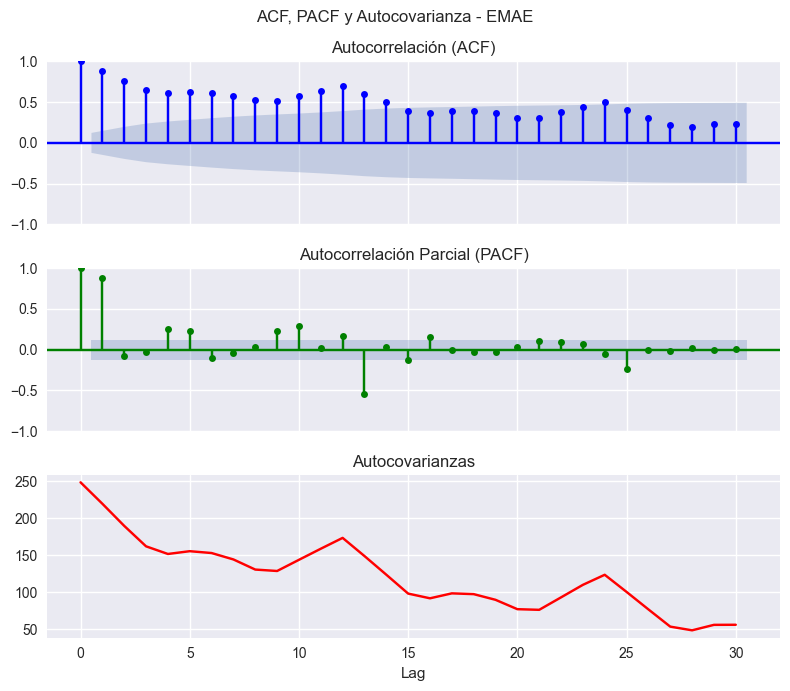

In [11]:
# Graficamos 
graficar_acf_pacf_autocov(df_emae, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - EMAE")

- La ACF muestra una caída lenta y gradual, con valores significativamente distintos de cero incluso después de varios rezagos (lags). Este comportamiento sugiere no estacionariedad: cuando las autocorrelaciones se mantienen altas y decaen lentamente.
- La PACF muestra solo el primer rezago significativo, lo que sugiere que si la serie es estacionaria, un modelo AR(1) podría ajustarla bien. 
- Parece haber estacionalidad cada 12 lags...

#### Análisis de la primera diferencia de la serie

In [12]:
# Aplicamos primera diferencia, para ver si se puede eliminar la estacionariedad
emae_diff = df_emae.diff().dropna()

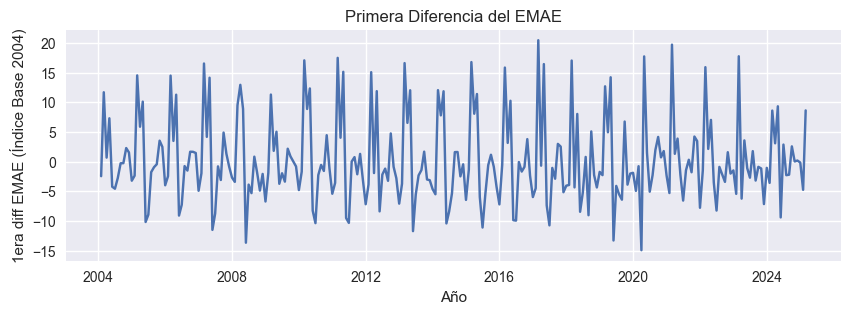

In [13]:
# Graficamos la primera diferencia
graficar(emae_diff, 
         titulo='Primera Diferencia del EMAE', 
         xlabel='Año', 
         ylabel='1era diff EMAE (Índice Base 2004)', 
         figsize=(10, 3))

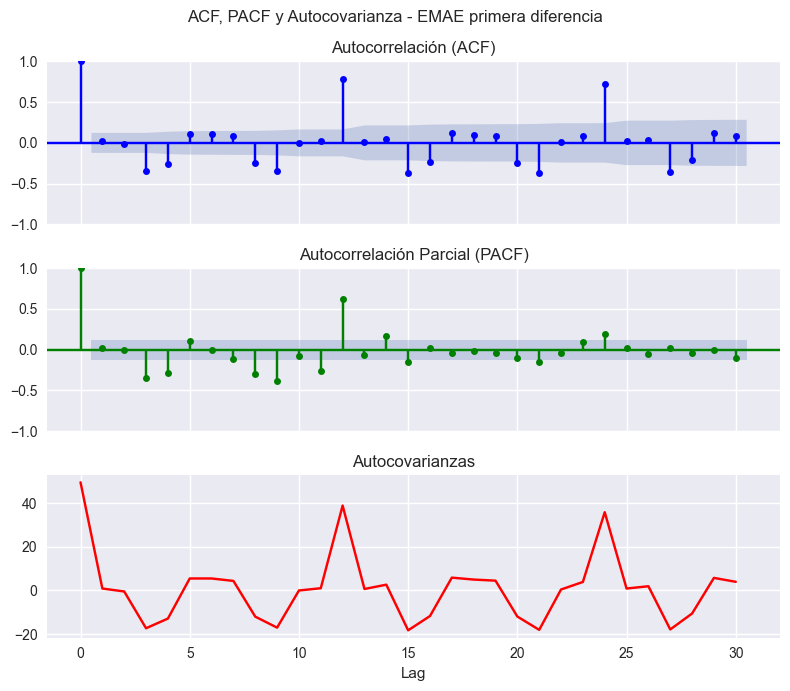

In [14]:
# Y su ACF, PACF y autocovarianzas
graficar_acf_pacf_autocov(emae_diff, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - EMAE primera diferencia")

- La serie parece estacionaria tras la primera diferencia → d=1
- Hay indicios de estacionalidad de orden 12, tanto en ACF como PACF → posible componente estacional SARIMA con s=12
- Un modelo candidato podría ser SARIMA(1,1,0)(1,0,0)[12]

#### Test Dickey-Fuller Aumentado

In [15]:
# Función para realizar test ADF
# Se utiliza el mismo que proporcionó el profesor en la clase de práctica
# Se incorporó un componente adicional expresa si se rechaza o no la hipótesis nula del test, construido con ChatGPT

def print_test_adf(y):
    resultado = adfuller(y.dropna())
    estadistico_adf = resultado[0]
    p_valor = resultado[1]
    criticos = resultado[4]

    print('Estadístico ADF: %f' % estadistico_adf)
    print('p-valor: %f' % p_valor)
    print('Valores críticos:')
    for clave, valor in criticos.items():
        print(f'   {clave}: {valor:.3f}')

    if p_valor < 0.05:
        print("✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.")
    else:
        print("⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.")

In [16]:
# Testeamos la serie sin diferenciar
print_test_adf(df_emae)

Estadístico ADF: -2.507129
p-valor: 0.113749
Valores críticos:
   1%: -3.458
   5%: -2.874
   10%: -2.573
⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.


In [17]:
# Testeamos la serie diferenciada
print_test_adf(emae_diff)

Estadístico ADF: -4.197176
p-valor: 0.000666
Valores críticos:
   1%: -3.458
   5%: -2.874
   10%: -2.573
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


#### Componentes deterministicos - Test de Raíces Unitarias

In [18]:
# Función para realizar los tres test de raíces unitarias
# Función realizada con ChatGPT

def adf_test_multiple(series):
    opciones = {
        'n': 'Sin constante (None)',
        'c': 'Con constante (Drift)',
        'ct': 'Con constante y tendencia (Trend)'
    }

    for reg, descripcion in opciones.items():
        print(f"\n===== Test ADF - {descripcion} =====")
        resultado = adfuller(series.dropna(), regression=reg, autolag='AIC')
        estadistico = resultado[0]
        p_valor = resultado[1]
        criticos = resultado[4]

        print(f'Estadístico ADF: {estadistico:.4f}')
        print(f'p-valor: {p_valor:.4f}')
        print('Valores críticos:')
        for clave, valor in criticos.items():
            print(f'   {clave}: {valor:.3f}')

        if p_valor < 0.05:
            print("✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.")
        else:
            print("⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.")


In [19]:
# Testeamos la serie sin diferenciar
adf_test_multiple(df_emae)


===== Test ADF - Sin constante (None) =====
Estadístico ADF: 0.8112
p-valor: 0.8869
Valores críticos:
   1%: -2.575
   5%: -1.942
   10%: -1.616
⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estadístico ADF: -2.5071
p-valor: 0.1137
Valores críticos:
   1%: -3.458
   5%: -2.874
   10%: -2.573
⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estadístico ADF: -2.4864
p-valor: 0.3348
Valores críticos:
   1%: -3.997
   5%: -3.429
   10%: -3.138
⚠️ No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.


In [20]:
# Testeamos la serie diferenciada
adf_test_multiple(emae_diff)


===== Test ADF - Sin constante (None) =====
Estadístico ADF: -4.0716
p-valor: 0.0001
Valores críticos:
   1%: -2.575
   5%: -1.942
   10%: -1.616
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estadístico ADF: -4.1972
p-valor: 0.0007
Valores críticos:
   1%: -3.458
   5%: -2.874
   10%: -2.573
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estadístico ADF: -4.2757
p-valor: 0.0034
Valores críticos:
   1%: -3.997
   5%: -3.429
   10%: -3.138
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


Es razonable considerar que la serie tenga un componente no estacional autorregresivo de orden 1, AR(1), es decir, p = 1.

#### Análisis de la segunda diferencia de la serie

In [21]:
# Calculamos la serie diferenciada dos veces
emae_diff_2 = emae_diff.diff().dropna()

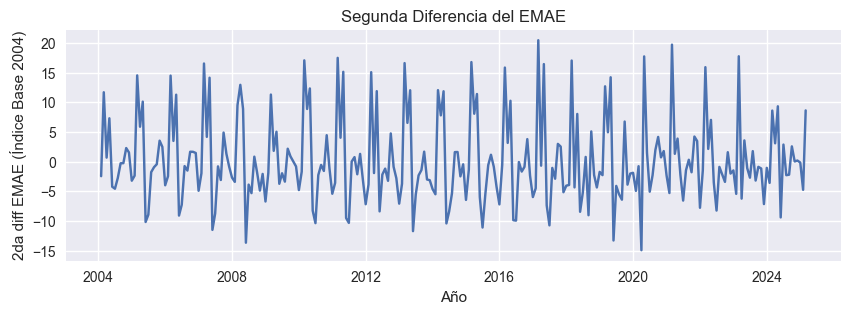

In [22]:
# Graficamos
graficar(emae_diff, 
         titulo='Segunda Diferencia del EMAE', 
         xlabel='Año', 
         ylabel='2da diff EMAE (Índice Base 2004)')

In [23]:
# Testeamos
print_test_adf(emae_diff_2)

Estadístico ADF: -8.428485
p-valor: 0.000000
Valores críticos:
   1%: -3.458
   5%: -2.874
   10%: -2.573
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


In [24]:
# Tesetamos raíces unitarias
adf_test_multiple(emae_diff_2)


===== Test ADF - Sin constante (None) =====
Estadístico ADF: -8.4473
p-valor: 0.0000
Valores críticos:
   1%: -2.575
   5%: -1.942
   10%: -1.616
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estadístico ADF: -8.4285
p-valor: 0.0000
Valores críticos:
   1%: -3.458
   5%: -2.874
   10%: -2.573
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estadístico ADF: -8.4248
p-valor: 0.0000
Valores críticos:
   1%: -3.997
   5%: -3.429
   10%: -3.138
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


#### Diferenciación
¿Cuántas veces debemos diferenciar? Realizamos diferentes tests para determinarlo. 

In [25]:
# Creamos una función que lleva a cabo diferentes tests de diferenciación óptima
# A partir de la proporcionada por el profesor, fine-tuneada con ChatGPT

def test_estacionariedad(y, alpha=0.05):
    print("🔍 Test de estacionariedad sugerida por distintos métodos")
    print("="*60)
    
    # Calcular cantidad de diferenciaciones sugeridas
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')

    print(f"📉 ADF test sugiere:   {n_adf} diferenciación(es)")
    print(f"📈 KPSS test sugiere: {n_kpss} diferenciación(es)")
    print(f"📉 PP test sugiere:    {n_pp} diferenciación(es)")
    print("-"*60)

    # Evaluar si al menos uno requiere diferenciación
    if any(test > 0 for test in [n_adf, n_kpss, n_pp]):
        print("⚠️ Al menos uno de los tests sugiere diferenciar → Se recomienda aplicar diferenciación.")
    else:
        print("✅ Ningún test sugiere diferenciar → La serie probablemente es estacionaria.")
    
    print("="*60)

In [26]:
test_estacionariedad(df_emae)

🔍 Test de estacionariedad sugerida por distintos métodos
📉 ADF test sugiere:   0 diferenciación(es)
📈 KPSS test sugiere: 1 diferenciación(es)
📉 PP test sugiere:    0 diferenciación(es)
------------------------------------------------------------
⚠️ Al menos uno de los tests sugiere diferenciar → Se recomienda aplicar diferenciación.


In [27]:
test_estacionariedad(emae_diff)

🔍 Test de estacionariedad sugerida por distintos métodos
📉 ADF test sugiere:   0 diferenciación(es)
📈 KPSS test sugiere: 0 diferenciación(es)
📉 PP test sugiere:    0 diferenciación(es)
------------------------------------------------------------
✅ Ningún test sugiere diferenciar → La serie probablemente es estacionaria.


- Observando los resultados de los tests, lo recomendable es aplicar una primera diferencia para eliminar la estacionariedad
- Esto implica que, en la construcción del modelo, tendremos un parámetro d=1

----
## 5. Análisis de estacionalidad

In [28]:
# Intuimos que la serie tiene estacionalidad cada 12 meses, por los graficos de ACF y PACF
# Aplicamos la 12ava diferencia a la serie original
emae_diff_12 = df_emae - df_emae.shift(12)
emae_diff_12 = emae_diff_12.dropna()

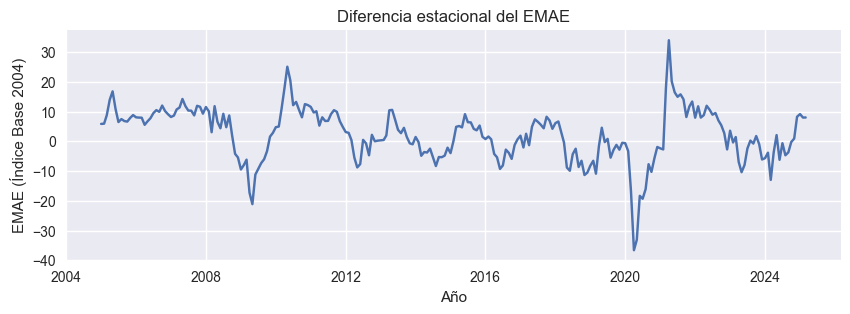

In [29]:
# Graficamos la serie
graficar(emae_diff_12, 
         titulo='Diferencia estacional del EMAE', 
         xlabel='Año', 
         ylabel='EMAE (Índice Base 2004)', 
         figsize=(10, 3))

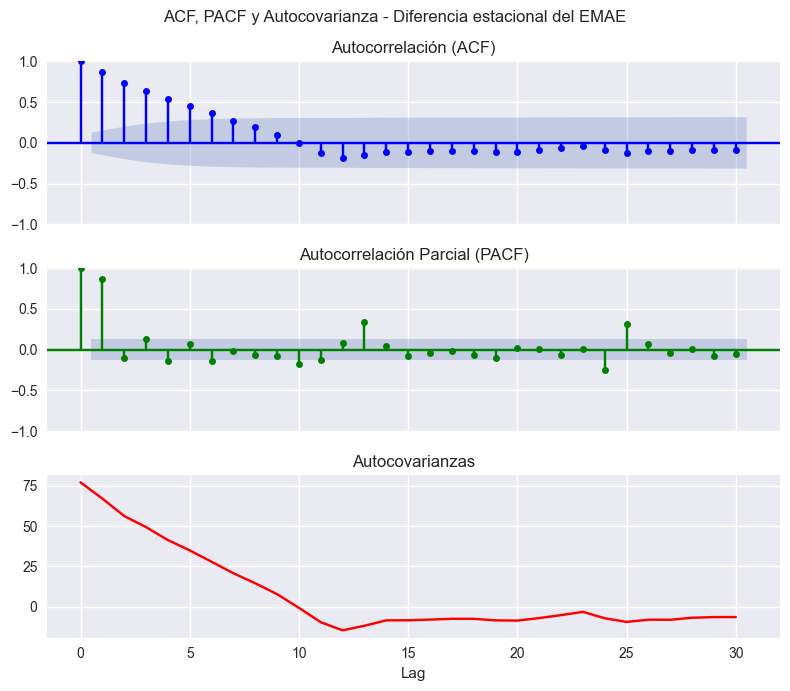

In [30]:
# ACF, PACF, Autocovarianzas
graficar_acf_pacf_autocov(emae_diff_12, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - Diferencia estacional del EMAE")

In [31]:
# Aplicamos la doceava diferencia, a la primera diferencia de la serie
emae_diff_1_12 = emae_diff - emae_diff.shift(12)
emae_diff_1_12 = emae_diff_1_12.dropna()

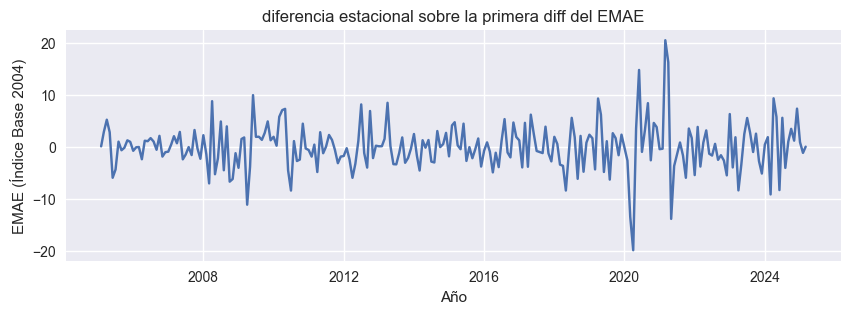

In [32]:
# Graficamos la serie
graficar(emae_diff_1_12, 
         titulo='diferencia estacional sobre la primera diff del EMAE', 
         xlabel='Año', 
         ylabel='EMAE (Índice Base 2004)', 
         figsize=(10, 3))

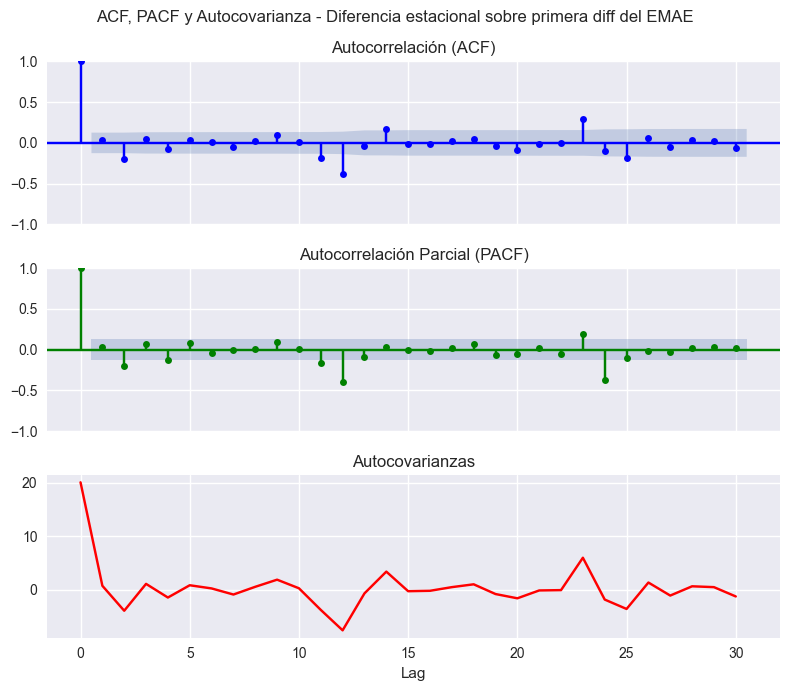

In [33]:
# ACF, PACF, Autocovarianzas
graficar_acf_pacf_autocov(emae_diff_1_12, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - Diferencia estacional sobre primera diff del EMAE")

- Parece que sigue habiendo indicios de estacionalidad, observamos rezagos significativos en lags 12, 24...
- Por lo que podría proponerse una segunda diferencia estacional


----
## 6. Analizar la posibilidad de transformación Box-Cox

Al analizar la serie gráficamente - específicamente el gráfico de la doceava diferencia estacional sobre la primera diferencia, existen indicios de heterocedasticidad, observando cambios en la magnitud de las fluctuaciones. Se realizará una transformación de Box-Cox a la serie original con el objetivo de estabilizar la varianza. Esto puede ayudar a que los residuos del modelo final sean más normales y con varianza constante.

#### Test de Jarque Bera para la normalidad de los residuos

In [34]:
# Creamos una función para el test Jarque Bera con ChatGPT 
def test_jarquebera(serie):
    jb_stat, jb_pvalue = jarque_bera(serie)

    print("===== Test de normalidad Jarque-Bera =====")
    print(f"Estadístico Jarque-Bera: {jb_stat:.4f}")
    print(f"p-valor: {jb_pvalue:.4f}")

    if jb_pvalue > 0.05:
        print("✅ No se rechaza la hipótesis nula: los residuos tienen distribución normal (al 5%)")
    else:
        print("❌ Se rechaza la hipótesis nula: los residuos NO siguen una distribución normal (al 5%)")

In [35]:
# Test sobre los datos originales 
test_jarquebera(df_emae)

===== Test de normalidad Jarque-Bera =====
Estadístico Jarque-Bera: 27.7583
p-valor: 0.0000
❌ Se rechaza la hipótesis nula: los residuos NO siguen una distribución normal (al 5%)


In [36]:
# Aplicamos la transformación Box-Cox
emae_boxcox, lambda_bc = boxcox(df_emae.values.flatten())
print(f"Lambda óptimo para Box-Cox: {lambda_bc}")

Lambda óptimo para Box-Cox: 3.4314872656575917


In [37]:
# Creamos la serie transformada con el mismo índice temporal
emae_boxcox = pd.Series(emae_boxcox, index=df_emae.index)

In [38]:
# Mostramos los primeros 5 valores
print("Primeros 5 valores de la serie transformada con Box-Cox:")
print(emae_boxcox[:5])

Primeros 5 valores de la serie transformada con Box-Cox:
indice_tiempo
2004-01-01    1.634409e+06
2004-02-01    1.491267e+06
2004-03-01    2.266196e+06
2004-04-01    2.318841e+06
2004-05-01    2.936771e+06
Freq: MS, dtype: float64


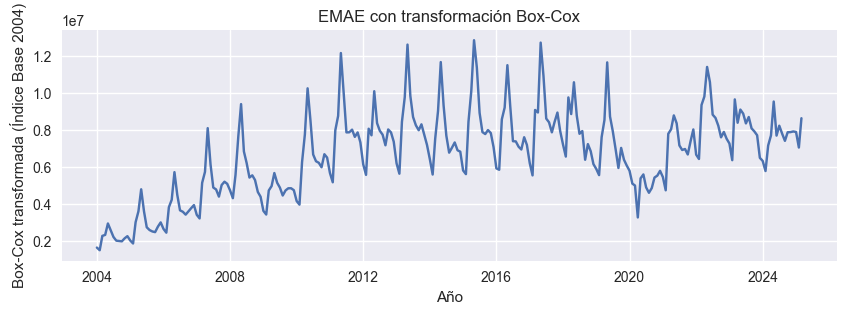

In [39]:
# Graficamos
graficar(emae_boxcox,
         titulo='EMAE con transformación Box-Cox',
         xlabel='Año',
         ylabel='Box-Cox transformada (Índice Base 2004)',
         figsize=(10, 3))

In [40]:
# Test sobre los datos transformados
test_jarquebera(emae_boxcox)

===== Test de normalidad Jarque-Bera =====
Estadístico Jarque-Bera: 0.4362
p-valor: 0.8041
✅ No se rechaza la hipótesis nula: los residuos tienen distribución normal (al 5%)


---- 
## 7. Partición *train* y *test set*

#### Sobre los datos originales, con fines de visualización

In [41]:
# Tomamos la columna del EMAE como una Serie
serie = df_emae[df_emae.columns[0]]

In [42]:
# Definimos el tamaño del corte: 90% para el train, 10% para el test
n_total = len(serie)
n_train = int(n_total * 0.9)

In [43]:
# División train / test
train = serie.iloc[:n_train]
test = serie.iloc[n_train:]

In [44]:
# Mostramos tamaños
print(f"Observaciones totales: {n_total}")
print(f"Train: {len(train)} datos")
print(f"Test: {len(test)} datos")

Observaciones totales: 255
Train: 229 datos
Test: 26 datos


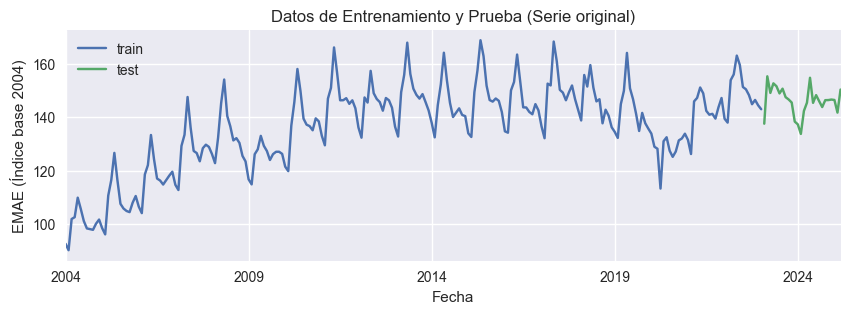

In [45]:
# Observamos los datos particionados
fig, ax = plt.subplots(figsize=(10, 3))
train.plot(ax=ax)
test.plot(ax=ax)
plt.title("Datos de Entrenamiento y Prueba (Serie original)")
plt.legend(['train', 'test'])
plt.xlabel('Fecha')
plt.ylabel('EMAE (Índice base 2004)')
plt.show()

#### Sobre los datos transformados con Box-Cox
Ya que son los que vamos a utilizar para estimar el modelo

In [46]:
# Dividimos en train y test (90% - 10%) sobre los datos transformados
split_index = int(len(emae_boxcox) * 0.9)
train_boxcox = emae_boxcox.iloc[:split_index]
test_boxcox = emae_boxcox.iloc[split_index:]

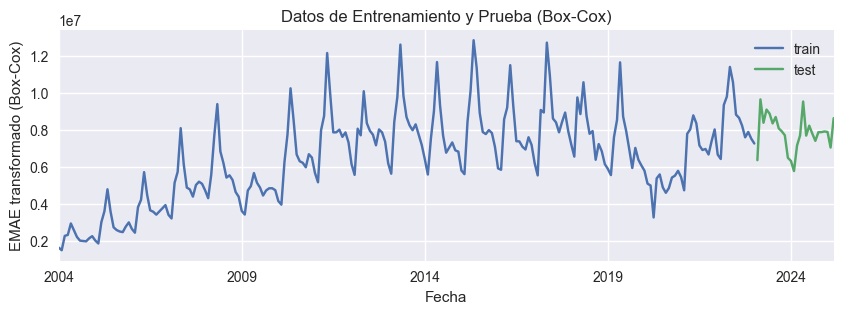

In [47]:
# Graficar
fig, ax = plt.subplots(figsize=(10, 3))
train_boxcox.plot(ax=ax)
test_boxcox.plot(ax=ax)
plt.title("Datos de Entrenamiento y Prueba (Box-Cox)")
plt.xlabel("Fecha")
plt.ylabel("EMAE transformado (Box-Cox)")
plt.legend(['train', 'test'])
plt.show()

-----
## 8. Estimación del modelo

A partir de lo observado gráficamente, y aplicando los tests correspondientes, podemos inferir un modelo SARIMA(p,d,q)(P,D,Q)s con los siguientes parámetros: 

Tendencia:
- Luego de aplicar la primera diferencia, los tests de ADF confirmaron estacionariedad. **d=1**

Estacionalidad: 
- El patrón visual de la serie y los picos en los lags 12 y 24 de la ACF indicaron una estacionalidad anual (mensual). Por lo tanto, se establece el periodo estacional en **s = 12**.
- Fue necesario aplicar una diferencia estacional (lag 12) para eliminarla **D=1**
- Pero no se eliminó por completo, por lo que se analizará una segunda diferenciación estacional **D=2**

Componente autorregresivo:
- En la PACF de la serie sin diferenciar, se observó un corte claro en el primer rezago, y el resto cae dentro del intervalo de confianza. **AR(1), p=1**

Componente de media móvil 
- Inicialmente intentamos con **MA(1), q=1**

Componente autorregresivo estacional: 
- La PACF mostró un pico significativo en el lag 12, lo que sugiere una dependencia estacional de tipo autorregresiva, entonces **P=1**

Componente media móvil estacional: 
- La ACF mostró picos significativos en lags 12 y 24, lo que sugiere una componente MA estacional.
- Por simplicidad y parsimonia, se prueba primero con **Q = 1**, pero luego se intenta un **Q=2**




#### Primer modelo: SARIMA(1,1,1)(1,1,1)12

In [48]:
# Propuesta inicial de parametros del modelo 
order = (1, 1, 1)          # ARIMA(p,d,q)
seasonal_order = (1, 1, 1, 12)  # SARIMA(P,D,Q,s)

In [49]:
# Ajustamos el modelo SARIMA
modelo_sarima = SARIMAX(train_boxcox, 
                        order=order, 
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

results = modelo_sarima.fit(disp=False)

# Resumen del modelo
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  229
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3004.333
Date:                            Wed, 16 Jul 2025   AIC                           6018.667
Time:                                    14:28:34   BIC                           6035.208
Sample:                                01-01-2004   HQIC                          6025.359
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8137      0.117     -6.982      0.000      -1.042      -0.585
ma.L1          0.8939      0.097   

#### Segundo modelo: SARIMA(1,1,1)(0,1,1)12

In [50]:
# Probamos quitando el componente autorregresivo estacional, ya que no es estadísticamente significativo
# Segunda propuesta
order_2 = (1, 1, 1)          # ARIMA(p,d,q)
seasonal_order_2 = (0, 1, 1, 12)  # SARIMA(P,D,Q,s)

In [51]:
# Ajustamos el modelo SARIMA 2
modelo_sarima_2 = SARIMAX(train_boxcox, 
                        order=order_2, 
                        seasonal_order=seasonal_order_2,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

results_2 = modelo_sarima_2.fit(disp=False)

# Resumen del modelo
print(results_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  229
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3004.985
Date:                            Wed, 16 Jul 2025   AIC                           6017.971
Time:                                    14:28:34   BIC                           6031.204
Sample:                                01-01-2004   HQIC                          6023.325
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8429      0.109     -7.723      0.000      -1.057      -0.629
ma.L1          0.9072      0.092   

#### Tercer modelo: SARIMA(1,1,1)(0,1,2)12

In [52]:
# Probamos agregando un componente media movil estacional Q = 2
# Tercera propuesta
order_3 = (1, 1, 1)          # ARIMA(p,d,q)
seasonal_order_3 = (0, 1, 2, 12)  # SARIMA(P,D,Q,s)

In [53]:
# Ajustamos el modelo SARIMA 3
modelo_sarima_3 = SARIMAX(train_boxcox, 
                        order=order_3, 
                        seasonal_order=seasonal_order_3,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

results_3 = modelo_sarima_3.fit(disp=False)

# Resumen del modelo
print(results_3.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  229
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -2828.481
Date:                                 Wed, 16 Jul 2025   AIC                           5666.963
Time:                                         14:28:37   BIC                           5683.198
Sample:                                     01-01-2004   HQIC                          5673.539
                                          - 01-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8798      0.050    -17.442      0.000      -0.979      -0

#### Cuarto modelo, SARIMA(1,1,1)(0,1,2)12 y agregamos un intercepto

In [54]:
# Debemos crear un vector de unos del mismo largo que el set de entrenamiento
exog_const = np.ones(len(train_boxcox))

In [55]:
# Ajustar el modelo SARIMA con intercepto
modelo_sarima_4 = SARIMAX(train_boxcox, 
                          order=order_3, 
                          seasonal_order=seasonal_order_3,
                          exog=exog_const,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_4 = modelo_sarima_4.fit(disp=False)

# Mostrar resumen
print(results_4.summary())

# El intercepto es significativo. 
# El segundo componente de mediamovil estacional deja de serlo

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  229
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -2828.481
Date:                                 Wed, 16 Jul 2025   AIC                           5668.963
Time:                                         14:28:39   BIC                           5688.445
Sample:                                     01-01-2004   HQIC                          5676.855
                                          - 01-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.633e-07   3.36e-09     78.262      0.000    2.57e-07     2.7

#### Quinto modelo, SARIMA(1,1,1)(0,1,1)12 con intercepto
- Sacamos el componente media movil estacional no significativo.
- Y dejamos el intercepto 

In [56]:
# Ajustar el modelo SARIMA con intercepto, con Q=1
modelo_sarima_5 = SARIMAX(train_boxcox, 
                          order=order_2, 
                          seasonal_order=seasonal_order_2,
                          exog=exog_const,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_5 = modelo_sarima_5.fit(disp=False)

# Mostrar resumen
print(results_5.summary())

# El intercepto es significativo. 
# El segundo componente de mediamovil estacional deja de serlo

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  229
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3004.985
Date:                            Wed, 16 Jul 2025   AIC                           6019.971
Time:                                    14:28:40   BIC                           6036.512
Sample:                                01-01-2004   HQIC                          6026.663
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.266e-07   9.22e-09     57.084      0.000    5.09e-07    5.45e-07
ar.L1         -0.8429      0.109   

## Con un algoritmo automatizado

#### El mejor modelo sin componente estacional

In [57]:
# Función autoarima, el mejor modelo arima: 
stepwise_fit = auto_arima(train_boxcox, 
                          trace=True,
                          suppress_warnings=True)
# el mejor modelo es (4,1,3)(0,0,0)[0]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6994.676, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7052.333, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7054.092, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7054.115, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7050.424, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7033.508, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7027.329, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6979.687, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7011.113, Time=0.88 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=6977.852, Time=0.67 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=7010.142, Time=0.24 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=6978.909, Time=1.11 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=6974.464, Time=0.83 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7000.174, Time=0.34 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept

In [58]:
best_arima = SARIMAX(train_boxcox, 
                          order=(4,1,3), 
                          seasonal_order=(0,0,0,0),
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_arima = best_arima.fit(disp=False)

# Mostrar resumen
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -3414.291
Date:                Wed, 16 Jul 2025   AIC                           6844.581
Time:                        14:29:01   BIC                           6871.874
Sample:                    01-01-2004   HQIC                          6855.598
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2150      0.098     -2.197      0.028      -0.407      -0.023
ar.L2         -0.0149      0.019     -0.770      0.441      -0.053       0.023
ar.L3         -0.9868      0.018    -54.518      0.0

#### El mejor modelo, con comp. estacional, entre rango (0,3) para los parámetros. 

In [59]:
# Le imponemos parámetros, que busque para p, q, P, y Q dentro de un rango (0,3)
stepwise_sarima = auto_arima(
    train_boxcox,
    start_p     = 0,
    start_q     = 0,
    max_p       = 3,
    max_q       = 3,
    d           = None,      # deja que lo elija automáticamente
    seasonal    = True,
    m           = 12,        # periodicidad estacional
    start_P     = 0,
    start_Q     = 0,
    max_P       = 3,
    max_Q       = 3,
    D           = None,      # automática
    trace       = True,
    error_action    = 'ignore',
    suppress_warnings= True,
    stepwise        = True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7052.333, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6917.247, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6963.563, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7050.424, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=7054.092, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=6913.646, Time=0.34 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=6912.083, Time=0.95 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=6912.490, Time=1.25 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=6911.204, Time=0.77 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6909.313, Time=0.20 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6962.561, Time=0.10 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=6910.976, Time=1.47 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=6945.293, Time=1.67 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=6912.281, Time=2.80 sec
 ARIMA(0,1,0)(1,0,1

In [60]:
best_sarima = SARIMAX(train_boxcox, 
                          order=(3,1,2), 
                          seasonal_order=(1,0,1,12),
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_sarima = best_sarima.fit(disp=False)

# Mostrar resumen
print(results_sarima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  229
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -3204.207
Date:                              Wed, 16 Jul 2025   AIC                           6424.413
Time:                                      14:30:54   BIC                           6451.304
Sample:                                  01-01-2004   HQIC                          6435.281
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0691      0.298     -0.232      0.816      -0.652       0.514
ar.L2          0.65

#### El mejor modelo, imponiendo AR(1) y MA(1)

In [61]:
stepwise_sarima = auto_arima(
    train_boxcox,
    start_p=1,  max_p=1,    # fijamos p = 1
    start_q=1,  max_q=1,    # fijamos q = 1
    d=1,                    # fijamos d = 1
    seasonal=True,
    m=12,                   # s = 12
    start_P=0, max_P=3,     # buscamos P en [0…3]
    start_Q=0, max_Q=3,     # buscamos Q en [0…3]
    D=1,                    # fijamos D = 1 (puedes poner D=None para buscar)
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=6465.931, Time=0.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6472.098, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6448.482, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6430.052, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=6471.680, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=6430.255, Time=0.30 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=6429.845, Time=0.46 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=6431.586, Time=2.41 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=6431.418, Time=2.27 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=6429.732, Time=3.07 sec
 ARIMA(0,1,1)(2,1,3)[12]             : AIC=inf, Time=14.20 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=3.34 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=6430.067, Time=3.80 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=6428.522, Time=8.00 sec
 ARIMA(1,1,1)(0,1,3)[12]    

In [62]:
# Más allá de que hayamos impuesto 1 para los componentes no estacionales, nos recomendó otro mejor modelo. 
best_sarima2 = SARIMAX(train_boxcox, 
                          order=(0,1,0), 
                          seasonal_order=(0,1,2,12),
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_sarima2 = best_sarima2.fit(disp=False)

# Mostrar resumen
print(results_sarima2.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  229
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -2844.396
Date:                                 Wed, 16 Jul 2025   AIC                           5694.792
Time:                                         14:31:59   BIC                           5704.549
Sample:                                     01-01-2004   HQIC                          5698.744
                                          - 01-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.5516      0.058     -9.446      0.000      -0.666      -0

#### El mejor modelo, recorriendo un amplio rango de parámetros (y una función creada por ChatGPT)

In [63]:
best_aic   = np.inf
best_bic   = np.inf
best_cfg   = None
best_model = None

print(" Probando SARIMA(p,1,q)x(P,1,Q)[12]   AIC       BIC")
for p in range(0, 5):
    for q in range(0, 5):
        for P in range(0, 4):
            for Q in range(0, 4):
                try:
                    mod = SARIMAX(
                        train_boxcox,
                        order=(p, 1, q),
                        seasonal_order=(P, 1, Q, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    ).fit(disp=False)
                    aic = mod.aic
                    bic = mod.bic
                    print(f" SARIMA({p},1,{q})x({P},1,{Q})[12]  {aic:8.2f}  {bic:8.2f}")
                    if aic < best_aic:
                        best_aic   = aic
                        best_bic   = bic
                        best_cfg   = (p, 1, q, P, 1, Q, 12)
                        best_model = mod
                except Exception:
                    continue

print(f"\nMejor modelo: SARIMA{best_cfg[:3]}×{best_cfg[3:]}  AIC={best_aic:.2f}  BIC={best_bic:.2f}")

 Probando SARIMA(p,1,q)x(P,1,Q)[12]   AIC       BIC
 SARIMA(0,1,0)x(0,1,0)[12]   6443.20   6446.57
 SARIMA(0,1,0)x(0,1,1)[12]   6044.66   6051.28
 SARIMA(0,1,0)x(0,1,2)[12]   5694.79   5704.55
 SARIMA(0,1,0)x(0,1,3)[12]   5337.73   5350.48
 SARIMA(0,1,0)x(1,1,0)[12]   6092.35   6098.98
 SARIMA(0,1,0)x(1,1,1)[12]   6046.07   6056.01
 SARIMA(0,1,0)x(1,1,2)[12]   5695.69   5708.70
 SARIMA(0,1,0)x(1,1,3)[12]   5327.16   5343.10
 SARIMA(0,1,0)x(2,1,0)[12]   5729.42   5739.19
 SARIMA(0,1,0)x(2,1,1)[12]   5723.72   5736.75
 SARIMA(0,1,0)x(2,1,2)[12]   5680.63   5696.89
 SARIMA(0,1,0)x(2,1,3)[12]   5324.60   5343.72
 SARIMA(0,1,0)x(3,1,0)[12]   5372.17   5384.94
 SARIMA(0,1,0)x(3,1,1)[12]   5366.95   5382.92
 SARIMA(0,1,0)x(3,1,2)[12]   5346.91   5366.07
 SARIMA(0,1,0)x(3,1,3)[12]   5320.69   5343.00
 SARIMA(0,1,1)x(0,1,0)[12]   6413.48   6420.21
 SARIMA(0,1,1)x(0,1,1)[12]   6019.20   6029.12
 SARIMA(0,1,1)x(0,1,2)[12]   5668.60   5681.59
 SARIMA(0,1,1)x(0,1,3)[12]   5308.01   5323.92
 SARIMA(

KeyboardInterrupt: 

In [64]:
best_sarima3 = SARIMAX(train_boxcox, 
                          order=(0,1,4), 
                          seasonal_order=(3,1,3,12),
                          enforce_stationarity=False,
                          enforce_invertibility=False)

results_sarima3 = best_sarima3.fit(disp=False)

# Mostrar resumen
print(results_sarima3.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  229
Model:             SARIMAX(0, 1, 4)x(3, 1, [1, 2, 3], 12)   Log Likelihood               -2588.085
Date:                                    Wed, 16 Jul 2025   AIC                           5198.171
Time:                                            14:33:43   BIC                           5232.983
Sample:                                        01-01-2004   HQIC                          5212.292
                                             - 01-01-2023                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0840      0.113      0.746      0

----
## 9. Elección de modelo
Creamos una tabla resumen con las principales características de los modelos probados

In [65]:
# Lista de modelos seleccionados para hacer comparativa y su metadata
modelos = [
    {'nombre': 'Modelo 1', 'result': results, 'order': order, 'seasonal_order': seasonal_order},
    {'nombre': 'Modelo 2', 'result': results_3, 'order': order_3, 'seasonal_order': seasonal_order_3},
    {'nombre': 'Modelo 3', 'result': results_arima, 'order': (4,1,3), 'seasonal_order': (0,0,0,0)},
    {'nombre': 'Modelo 4', 'result': results_sarima2, 'order': (0,1,0), 'seasonal_order': (0,1,2,12)},
    {'nombre': 'Modelo 5', 'result': results_sarima3, 'order': (0,1,4), 'seasonal_order': (3,1,3,12)},
]

# Crear tabla
filas = []

for modelo in modelos:
    res = modelo['result']
    
    # Valores ajustados sobre el set de entrenamiento
    pred_train = res.fittedvalues

    # Alinear índices por si acaso
    y_true = train_boxcox.loc[pred_train.index]

    # Calcular MAPE en porcentaje
    mape = mean_absolute_percentage_error(y_true, pred_train) * 100

    # Contar coeficientes significativos (p < 0.05)
    pvals = res.pvalues
    significativos = sum(p < 0.05 for p in pvals)

    filas.append({
        'Modelo': modelo['nombre'],
        'ARIMA(p,d,q)': modelo['order'],
        'Seasonal(P,D,Q,s)': modelo['seasonal_order'],
        'AIC': round(res.aic, 2),
        'BIC': round(res.bic, 2),
        'MAPE Train (%)': round(mape, 2),
        'Coef. Significativos': f"{significativos}/{len(pvals)}"
    })

# Convertir a DataFrame
df_comparacion = pd.DataFrame(filas)
display(df_comparacion)


,Modelo,"ARIMA(p,d,q)","Seasonal(P,D,Q,s)",AIC,BIC,MAPE Train (%),Coef. Significativos
0,Modelo 1,"(1, 1, 1)","(1, 1, 1, 12)",6018.67,6035.21,8.96,4/5
1,Modelo 2,"(1, 1, 1)","(0, 1, 2, 12)",5666.96,5683.20,9.30,4/5
2,Modelo 3,"(4, 1, 3)","(0, 0, 0, 0)",6844.58,6871.87,13.15,6/8
3,Modelo 4,"(0, 1, 0)","(0, 1, 2, 12)",5694.79,5704.55,8.99,2/3
4,Modelo 5,"(0, 1, 4)","(3, 1, 3, 12)",5198.17,5232.98,8.65,1/11


Sin embargo: 
#### “La precisión de los pronósticos sólo se puede determinar considerando qué tan bien se desempeña un modelo con los nuevos datos que no se utilizaron al ajustar el modelo.”
Por lo que a continuación se calcularán distintas métricas sobre el conjunto de prueba. 


#### Generación de predicciones sobre el conjunto de testeo transformado con Box Cox

In [66]:
# Tamaño del test
n_test = len(test_boxcox)
print(n_test)

26


In [67]:
# Creamos una función que nos sirva para evaluar métricas
def evaluar_metricas(test_boxcox, test_pred):
    # 1. Cálculo de métricas
    mse  = mean_squared_error(test_boxcox, test_pred)
    mae  = mean_absolute_error(test_boxcox, test_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test_boxcox, test_pred) * 100

    # 2. Impresión formateada
    print(f'MSE:  {mse:.4f}')
    print(f'MAE:  {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.2f}%')

In [68]:
# Predicciones sobre el conjunto de testeo

# 1. Modelo 1 (sin exógenas)
pred_1 = results.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 1 ---')
evaluar_metricas(test_boxcox, pred_1)
print()

# 2. Modelo 2 (sin exógenas)
pred_2 = results_3.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 2 ---')
evaluar_metricas(test_boxcox, pred_2)
print()

# 3. Modelo 3 (sin exógenas)
pred_3 = results_arima.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 3 ---')
evaluar_metricas(test_boxcox, pred_3)
print()

# 4. Modelo 4 
pred_4 = results_sarima2.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 4 ---')
evaluar_metricas(test_boxcox, pred_4)
print()

# 5. Modelo 5 
pred_5 = results_sarima3.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 5 ---')
evaluar_metricas(test_boxcox, pred_5)
print()


--- Métricas Modelo 1 ---
MSE:  1977375526592.0454
MAE:  1174601.2446
RMSE: 1406191.8527
MAPE: 15.31%

--- Métricas Modelo 2 ---
MSE:  1742231699115.5061
MAE:  1088397.3113
RMSE: 1319936.2481
MAPE: 14.17%

--- Métricas Modelo 3 ---
MSE:  935809754624.3086
MAE:  775301.0609
RMSE: 967372.6038
MAPE: 9.62%

--- Métricas Modelo 4 ---
MSE:  1785632894767.3462
MAE:  1108996.2844
RMSE: 1336275.7555
MAPE: 14.46%

--- Métricas Modelo 5 ---
MSE:  1321827758792.7188
MAE:  959459.3230
RMSE: 1149707.6841
MAPE: 12.29%



#### Elección de modelo
Primando por un modelo parsimonioso, se escoge aquel con menor error MAPE y además con menor cantidad de coeficientes significativos. Por lo tanto, queda seleccionado el **modelo 4**.

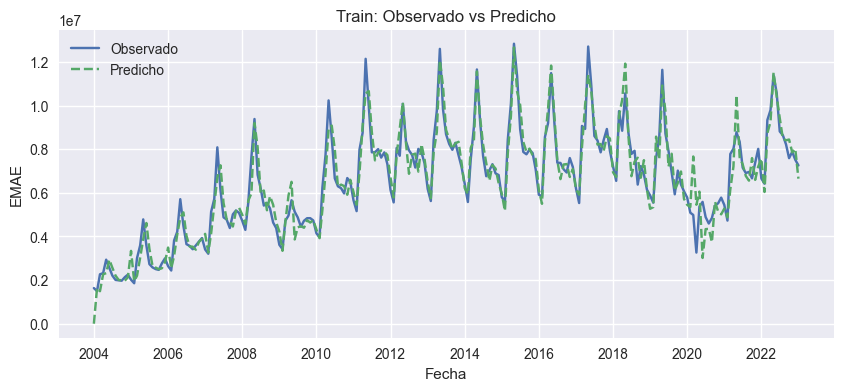

In [69]:
# Actual vs predicted en el conjunto de entrenamiento
train_pred = results_sarima2.predict(start=train_boxcox.index[0], end=train_boxcox.index[-1])

plt.figure(figsize=(10, 4))
plt.plot(train_boxcox, label='Observado')
plt.plot(train_pred, label='Predicho', linestyle='--')
plt.title("Train: Observado vs Predicho")
plt.xlabel("Fecha")
plt.ylabel("EMAE")
plt.legend()
plt.grid(True)
plt.show()

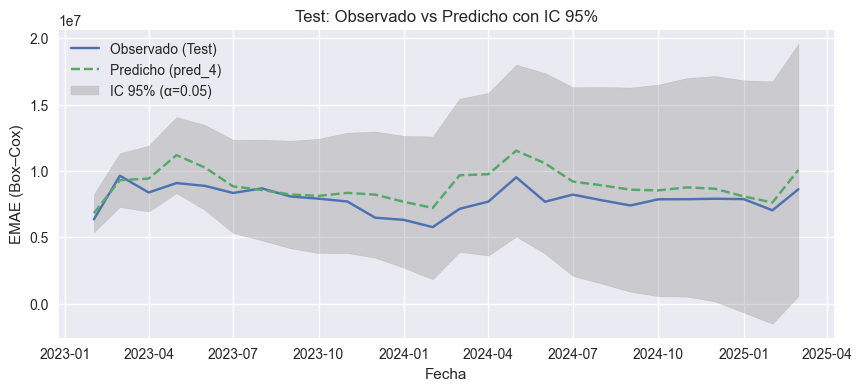

In [70]:
# Actual vs predicted en el conjunto de testeo

# 1. Calculamos de nuevo el forecast para obtener el IC
n_test = len(test_boxcox)
fc    = results_sarima2.get_forecast(steps=n_test)            
pred_4 = fc.predicted_mean                              
ci     = fc.conf_int(alpha=0.05)                        

# 2. Grafico Observado vs Predicho + IC
plt.figure(figsize=(10, 4))
plt.plot(test_boxcox.index, test_boxcox, label='Observado (Test)')
plt.plot(pred_4.index,        pred_4,       linestyle='--', label='Predicho (pred_4)')

# Sombrear entre el límite inferior y superior
plt.fill_between(
    ci.index,
    ci.iloc[:, 0],   # límite inferior
    ci.iloc[:, 1],   # límite superior
    color='gray',
    alpha=0.3,
    label='IC 95% (α=0.05)'
)

plt.title("Test: Observado vs Predicho con IC 95%")
plt.xlabel("Fecha")
plt.ylabel("EMAE (Box–Cox)")
plt.legend()
plt.grid(True)
plt.show()


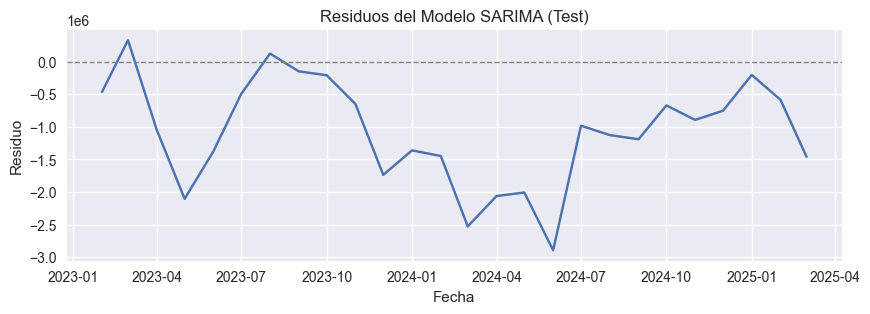

In [71]:
# 1. Calcular residuales en el conjunto de test (Box–Cox)
residuos_test = test_boxcox - pred_4

# 2. Gráfico de residuos sobre Test
plt.figure(figsize=(10, 3))
plt.plot(residuos_test, label='Residuo')
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title("Residuos del Modelo SARIMA (Test)")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.grid(True)
plt.show()

Los residuos en test quedan sistemáticamente por debajo de cero (sesgo negativo) y no se centran en cero, lo que indica que el modelo no generaliza bien ante el cambio de nivel en ese periodo.

----
## 10. Análisis de diagnóstico

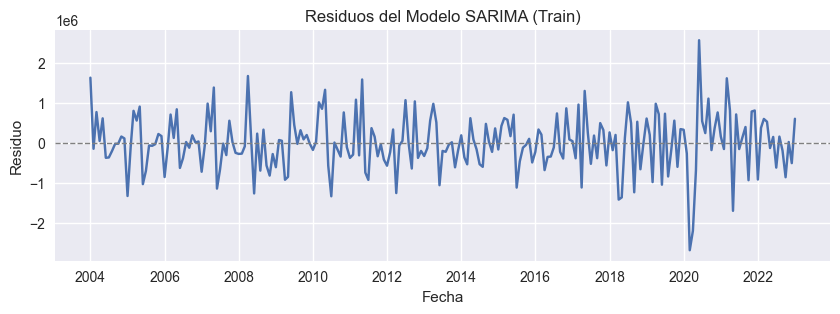

In [72]:
# Gráfico de residuos en el conjunto de entrenamiento 
residuos_train = results_sarima2.resid

plt.figure(figsize=(10, 3))
plt.plot(residuos_train)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title("Residuos del Modelo SARIMA (Train)")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.grid(True)
plt.show()

In [73]:
# Función para que grafique autocorrelaciones de los residuos del modelo 
def graficar_acf_pacf(serie, n_lags=50, titulo="Análisis de correlación temporal"):
    fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
    fig.suptitle(titulo, fontsize=12)
    plot_acf(serie, lags=n_lags, ax=axes[0], color='blue',
             vlines_kwargs={'colors':'blue'}, title='Autocorrelación (ACF)')
    plot_pacf(serie, lags=n_lags, ax=axes[1], color='green',
              vlines_kwargs={'colors':'green'}, method='ywm',
              title='Autocorrelación Parcial (PACF)')
    plt.tight_layout()
    plt.show()

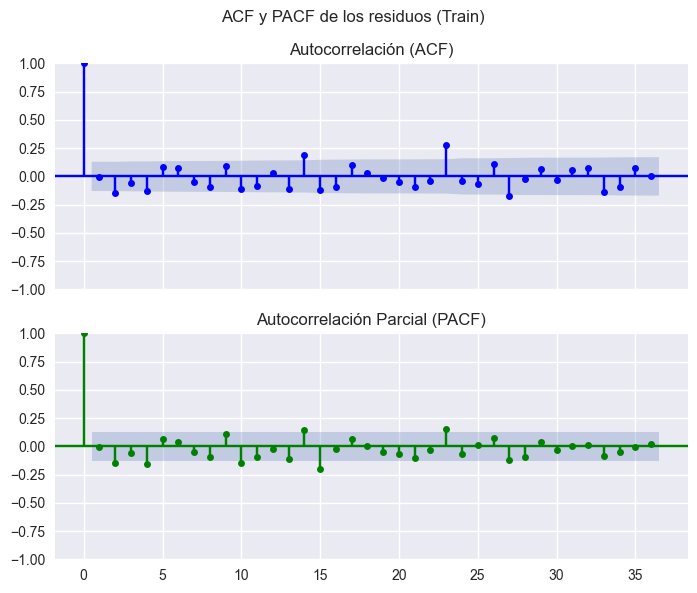

In [74]:
# Graficamos 
graficar_acf_pacf(residuos_train, n_lags=36, titulo="ACF y PACF de los residuos (Train)")

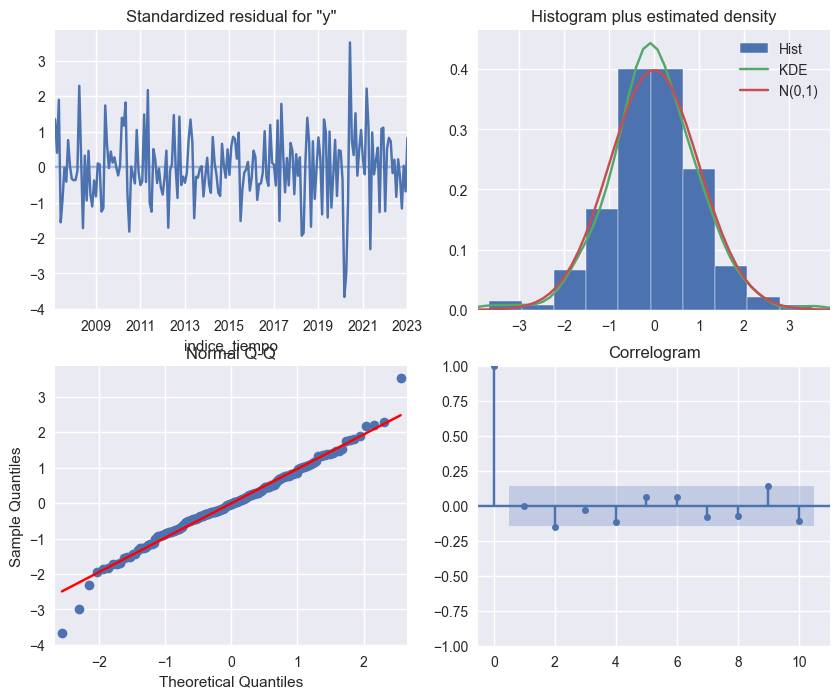

In [75]:
# Diagnóstico gráfico de residuos para el Modelo 3
fig_res_3 = results_sarima2.plot_diagnostics(figsize=(10, 8))
plt.show()

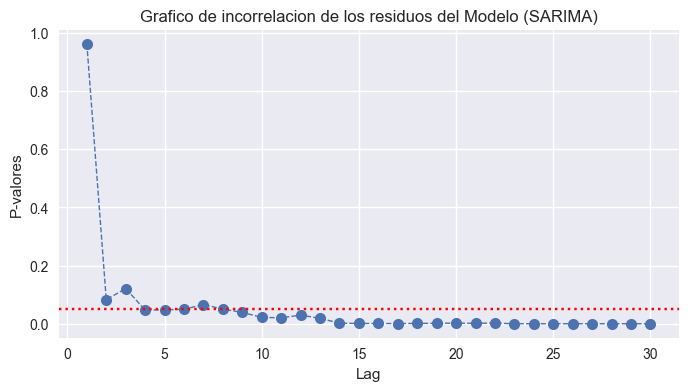

In [76]:
# Test de Ljung–Box y gráfico de p-valores para residuos del Modelo 3
Incorr_residuos_modelo4 = sm.stats.acorr_ljungbox(results_sarima2.resid, lags=30)
plt.figure(figsize=(8,4))
plt.plot(Incorr_residuos_modelo4.lb_pvalue, marker='o', markersize=8,
         linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del Modelo (SARIMA)")
plt.xlabel("Lag")
plt.ylabel("P-valores")
plt.axhline(0.05, color='red', linestyle=':')  # nivel de significancia 5%
plt.grid(True)
plt.show()

----
## 11. Forecast 

In [77]:
# Ajustamos el modelo sarima a toda la serie, no solo el conjunto de entrenamiento
model_full = SARIMAX(emae_boxcox,
                     order=(0,1,0),
                     seasonal_order=(0,1,2,12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

results_full = model_full.fit(disp=False)

# Mostrar resumen
print(results_full.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  255
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -3234.657
Date:                                 Wed, 16 Jul 2025   AIC                           6475.314
Time:                                         14:33:46   BIC                           6485.453
Sample:                                     01-01-2004   HQIC                          6479.410
                                          - 03-01-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.5776      0.060     -9.570      0.000      -0.696      -0

In [78]:
# Pronóstico a 12 meses 
n_forecast = 12
fc         = results_full.get_forecast(steps=n_forecast)
pred_bc    = fc.predicted_mean
ci_bc      = fc.conf_int(alpha=0.05)

In [80]:
# Invertir Box–Cox en pronóstico y CI
pred_orig = inv_boxcox(pred_bc, lambda_bc)
ci_orig = pd.DataFrame({
    'lower': inv_boxcox(ci_bc.iloc[:,0], lambda_bc),
    'upper': inv_boxcox(ci_bc.iloc[:,1], lambda_bc)
})

In [81]:
# Crear índice futuro de 12 meses
last_date    = emae_boxcox.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                             periods=n_forecast,
                             freq=emae_boxcox.index.freq or 'MS')
pred_orig.index = future_index
ci_orig.index   = future_index

In [82]:
# Reconstruir la serie histórica original
full_series = inv_boxcox(emae_boxcox, lambda_bc)

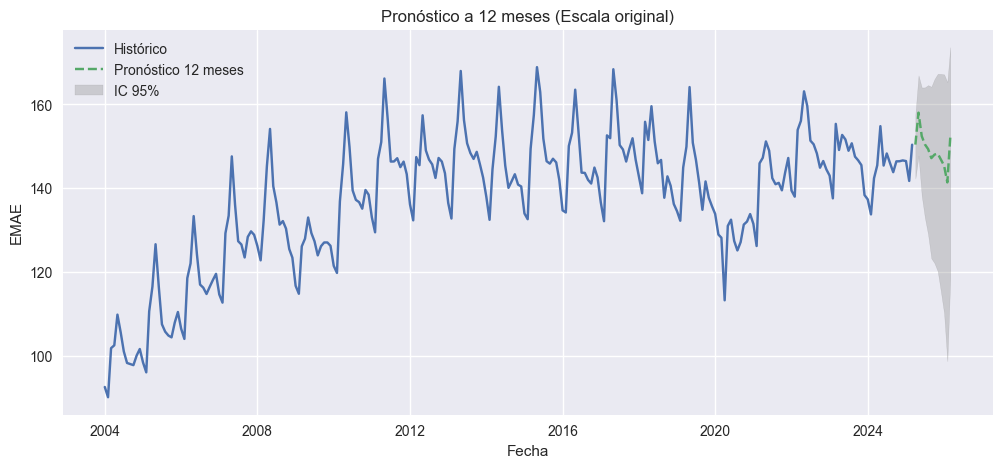

In [83]:
# 6. Graficar histórico + pronóstico + IC 95% (escala original)
plt.figure(figsize=(12,5))
plt.plot(full_series, label='Histórico')
plt.plot(pred_orig,   '--',   label='Pronóstico 12 meses')
plt.fill_between(ci_orig.index,
                 ci_orig['lower'],
                 ci_orig['upper'],
                 color='gray', alpha=0.3,
                 label='IC 95%')
plt.title("Pronóstico a 12 meses (Escala original)")
plt.xlabel("Fecha")
plt.ylabel("EMAE")
plt.legend()
plt.grid(True)
plt.show()

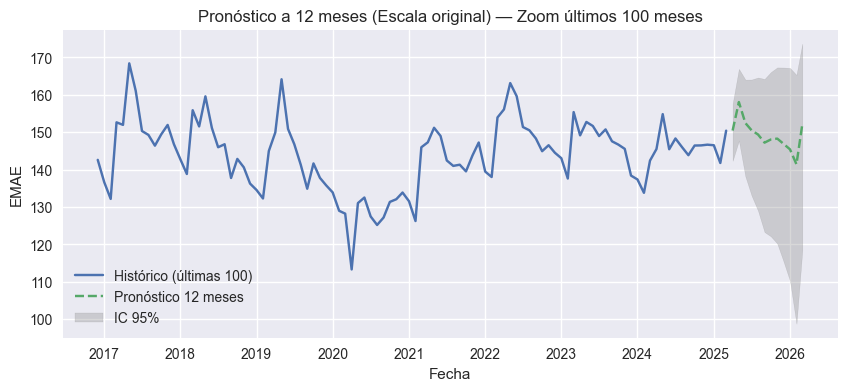

In [84]:
# Zoom para ver mejor el forecast
hist_tail = full_series.tail(100)

plt.figure(figsize=(10,4))
plt.plot(hist_tail, label='Histórico (últimas 100)')
plt.plot(pred_orig, '--', label='Pronóstico 12 meses')
plt.fill_between(ci_orig.index,
                 ci_orig['lower'],
                 ci_orig['upper'],
                 color='gray', alpha=0.3,
                 label='IC 95%')
plt.title("Pronóstico a 12 meses (Escala original) — Zoom últimos 100 meses")
plt.xlabel("Fecha")
plt.ylabel("EMAE")
plt.legend()
plt.grid(True)
plt.show()

----
## Modelo SARIMA-X
En este bloque añadimos variables exógenas para evaluar su relación con el EMAE y mejorar el ajuste del SARIMA–X:
- Tasa de devaluación mensual del tipo de cambio oficial.
- Dummy que represente el impacto de los primeros meses de la cuarentena (marzo–mayo 2020).

#### Tasa de devaluación

In [85]:
df_dev = pd.read_csv('tasa-devaluacion-tc-oficial.csv', parse_dates=['indice_tiempo'])
df_dev.set_index('indice_tiempo', inplace=True)
df_dev.index.freq = 'MS'
df_dev.head()

,tipo_cambio_valuacion_var_pct
indice_tiempo,
2003-03-01,-0.029436
2003-04-01,-0.055238
2003-05-01,-0.025040
2003-06-01,-0.006224
2003-07-01,-0.007809


In [86]:
df_dev.rename(columns={'tipo_cambio_valuacion_var_pct':'tasa_devaluacion'}, inplace=True)
df_dev.head()

,tasa_devaluacion
indice_tiempo,
2003-03-01,-0.029436
2003-04-01,-0.055238
2003-05-01,-0.025040
2003-06-01,-0.006224
2003-07-01,-0.007809


In [87]:
# Verificamos que el indice sea del tipo DatetimeIndex
print(df_dev.index)

# OK! datetime, y frecuencia mensual

DatetimeIndex(['2003-03-01', '2003-04-01', '2003-05-01', '2003-06-01',
               '2003-07-01', '2003-08-01', '2003-09-01', '2003-10-01',
               '2003-11-01', '2003-12-01',
               ...
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01'],
              dtype='datetime64[ns]', name='indice_tiempo', length=268, freq='MS')


In [88]:
# Verificamos la existencia de valores nulos
print("Valores faltantes:")
print(df_dev.isnull().values.any())

Valores faltantes:
False


In [89]:
# Convertimos a porcentaje 
df_dev['tasa_devaluacion_pct'] = df_dev['tasa_devaluacion'] * 100
df_dev.drop(columns=['tasa_devaluacion'], inplace=True)
df_dev.head()

,tasa_devaluacion_pct
indice_tiempo,
2003-03-01,-2.943552
2003-04-01,-5.523819
2003-05-01,-2.503957
2003-06-01,-0.622404
2003-07-01,-0.780893


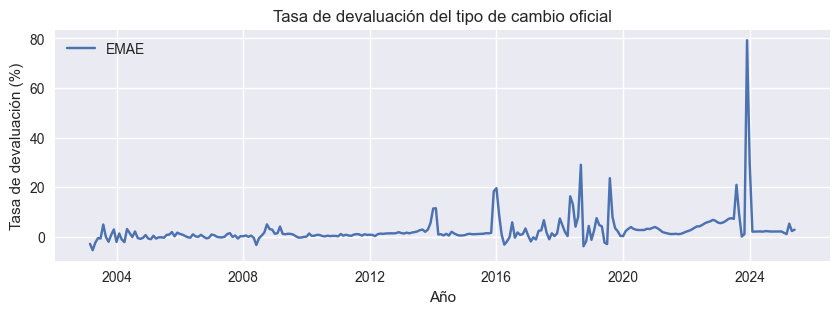

In [90]:
# Visualizamos la serie
graficar(df_dev['tasa_devaluacion_pct'], titulo='Tasa de devaluación del tipo de cambio oficial',
         xlabel='Año', ylabel='Tasa de devaluación (%)', figsize=(10, 3),
         usar_leyenda=True, label='EMAE')

In [91]:
# Test de estacionariedad sobre la tasa de devaluación 
print_test_adf(df_dev)

Estadístico ADF: -5.913758
p-valor: 0.000000
Valores críticos:
   1%: -3.455
   5%: -2.873
   10%: -2.573
✅ Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


In [92]:
# Pongo las variables en un mismo Dataframe
df = df_emae.join(df_dev, how='inner') # EMAE original, no boxcox

In [93]:
# Volvemos a transformar EMAE boxcox e incluimos en el dataframe
emae_boxcox, lambda_bc = boxcox(df['emae_original'])
df['emae_boxcox'] = emae_boxcox

In [94]:
# Imprimimos
df.head()

,emae_original,tasa_devaluacion_pct,emae_boxcox
indice_tiempo,,,
2004-01-01,92.627506,-2.183816,1.634409e+06
2004-02-01,90.186179,1.251166,1.491267e+06
2004-03-01,101.883298,-1.180078,2.266196e+06
2004-04-01,102.567430,-2.265531,2.318841e+06
2004-05-01,109.877504,3.038348,2.936771e+06


**Gráfico de autocorrelación cruzada CCF entre EMAE y Tasa de devaluación**

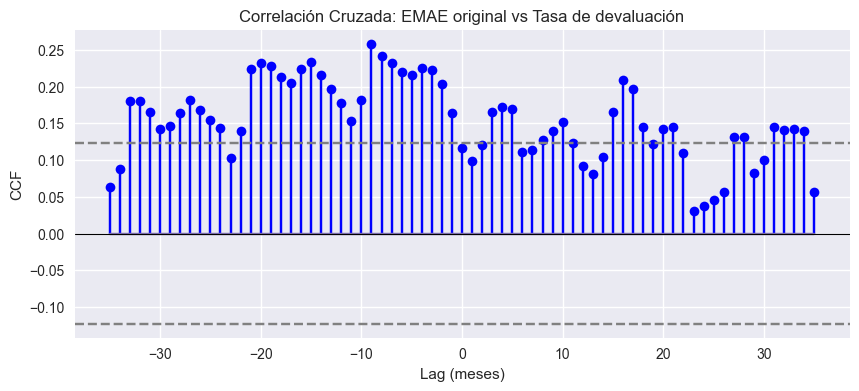

In [95]:
# Series a correlacionar
y = df['emae_original']
x = df['tasa_devaluacion_pct']

# Definimos rango de lags
lag_max = 35
lags = np.arange(-lag_max, lag_max+1)
ccf_vals = [y.corr(x.shift(lag)) for lag in lags]

# Graficamos
plt.figure(figsize=(10,4))
markers, stems, base = plt.stem(lags, ccf_vals)
plt.setp(markers, 'markerfacecolor', 'blue')
plt.setp(stems,   'color',        'blue')
plt.axhline(0, color='black', linewidth=0.8)

# Intervalo de confianza aproximado ±1.96/√N
conf = 1.96/np.sqrt(len(df))
plt.axhline( conf, color='gray', linestyle='--')
plt.axhline(-conf, color='gray', linestyle='--')
plt.title('Correlación Cruzada: EMAE original vs Tasa de devaluación')
plt.xlabel('Lag (meses)')
plt.ylabel('CCF')
plt.show()

La CCF entre la tasa de devaluación y la EMAE original es positiva y significativa (fuera de las líneas punteadas) prácticamente en todos los lags de −24 a +24. Eso suele ocurrir cuando ambas series comparten una fuerte tendencia y estacionalidad, y por tanto la correlación cruzada refleja ese comportamiento común más que una verdadera relación causal puntual.

Sin embargo: Para aislar efectos genuinos conviene diferenciar ambas series. 

**Gráfico de autocorrelación cruzada de las primeras diferencias**

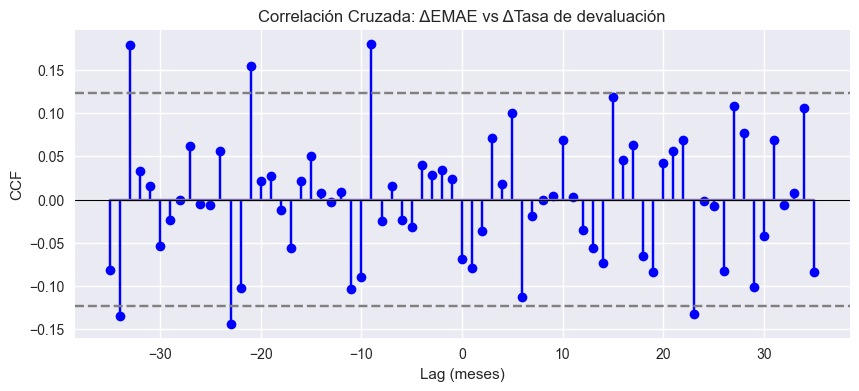

In [96]:
d_emae = df['emae_original'].diff()
d_dev  = df['tasa_devaluacion_pct'].diff()

valid = pd.concat([d_emae, d_dev], axis=1).dropna()
N     = len(valid)

ccf_diff  = [d_emae.corr(d_dev.shift(l)) for l in lags]

plt.figure(figsize=(10,4))
markers, stems, base = plt.stem(lags, ccf_diff)
plt.setp(markers, 'markerfacecolor', 'blue')
plt.setp(stems,   'color',        'blue')
plt.axhline(0, color='black', linewidth=0.8)

conf = 1.96/np.sqrt(N)
plt.axhline( conf, color='gray', linestyle='--')
plt.axhline(-conf, color='gray', linestyle='--')
plt.title('Correlación Cruzada: ΔEMAE vs ΔTasa de devaluación')
plt.xlabel('Lag (meses)')
plt.ylabel('CCF')
plt.show()

En este gráfico de CCF entre ΔEMAE y ΔTasa de devaluación, los tres picos que caen fuera de las líneas de confianza: *lag = –9, –21 y –33*, significan que:
- Lag = –9: un cambio en la tasa de devaluación tiende a anticiparse a un cambio en la EMAE 9 meses después.
- Lag = –21 y –33 son simplemente repeticiones estacionales de ese mismo efecto (21 = 12+9, 33 = 24+9), lo que indica que la respuesta de la EMAE a un shock de devaluación se replica anualmente.

Esto nos sugiere: 
- Efecto rezagado principal a 9 meses: vale la pena incluir ΔTasa_devaluaciónₜ₋₉ como regresor exógeno en el SARIMAX-X, ya que parece “predecir” los movimientos de actividad.

#### Dummy COVID

In [97]:
# Creamos la variable dummy que tome los valores 1 en Marzo, Abril, Mayo 2020
df['dummy_covid'] = 0
df.loc['2020-03-01':'2020-05-01', 'dummy_covid'] = 1
print(df['dummy_covid'].value_counts())

dummy_covid
0    252
1      3
Name: count, dtype: int64


#### El modelo SARIMAX
Con el shift(9)

In [98]:
# Creamos la variable de la tasa de devaluación rezagada (o desplazada) 9 períodos
df['dev_lag9'] = df['tasa_devaluacion_pct'].shift(9)

In [99]:
# Imprimimos
df.head(15)

,emae_original,tasa_devaluacion_pct,emae_boxcox,dummy_covid,dev_lag9
indice_tiempo,,,,,
2004-01-01,92.627506,-2.183816,1.634409e+06,0,NaN
2004-02-01,90.186179,1.251166,1.491267e+06,0,NaN
2004-03-01,101.883298,-1.180078,2.266196e+06,0,NaN
2004-04-01,102.567430,-2.265531,2.318841e+06,0,NaN
2004-05-01,109.877504,3.038348,2.936771e+06,0,NaN
2004-06-01,105.662406,1.414530,2.567881e+06,0,NaN
2004-07-01,101.106997,-0.230990,2.207490e+06,0,NaN
2004-08-01,98.355737,2.058415,2.008095e+06,0,NaN
2004-09-01,98.086375,-0.573040,1.989287e+06,0,NaN


In [118]:
# Descartamos los primeros 9 períodos con NaN
df_model = df.dropna(subset=['dev_lag9'])

In [119]:
# Definimos la variable Y, y variables exogenas
y = df_model['emae_boxcox']
X = df_model[['dev_lag9','dummy_covid']]

In [120]:
# Hacemos partición train - test 
train_size = int(len(y) * 0.9)
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]
X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]

In [121]:
# Ajuste del SARIMAX sobre el Training Set
model_x_train = SARIMAX(
    y_train,
    exog=X_train,
    order=(0,1,0),
    seasonal_order=(0,1,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_x_train = model_x_train.fit(disp=False)
print(results_x_train.summary())

                                        SARIMAX Results                                        
Dep. Variable:                             emae_boxcox   No. Observations:                  221
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -2708.988
Date:                                 Wed, 16 Jul 2025   AIC                           5427.976
Time:                                         14:38:41   BIC                           5444.024
Sample:                                     10-01-2004   HQIC                          5434.481
                                          - 02-01-2023                                         
Covariance Type:                                   opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
dev_lag9    -1.138e+04   1.05e+04     -1.079      0.281    -3.2e+04    9

#### Modelo SARIMAX sin shift

In [114]:
# Volvemos al Dataframe original 
df_model = df
df.head(5)

,emae_original,tasa_devaluacion_pct,emae_boxcox,dummy_covid,dev_lag9
indice_tiempo,,,,,
2004-01-01,92.627506,-2.183816,1.634409e+06,0,NaN
2004-02-01,90.186179,1.251166,1.491267e+06,0,NaN
2004-03-01,101.883298,-1.180078,2.266196e+06,0,NaN
2004-04-01,102.567430,-2.265531,2.318841e+06,0,NaN
2004-05-01,109.877504,3.038348,2.936771e+06,0,NaN


In [115]:
# Definimos la variable Y, y variables exogenas
y = df_model['emae_boxcox']
X = df_model[['tasa_devaluacion_pct','dummy_covid']]

In [116]:
# Hacemos partición train - test 
train_size = int(len(y) * 0.9)
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]
X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]

In [117]:
# Ajuste del SARIMAX sobre el Training Set
model_x_train = SARIMAX(
    y_train,
    exog=X_train,
    order=(0,1,0),
    seasonal_order=(0,1,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_x_train = model_x_train.fit(disp=False)
print(results_x_train.summary())

                                        SARIMAX Results                                        
Dep. Variable:                             emae_boxcox   No. Observations:                  229
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -2827.870
Date:                                 Wed, 16 Jul 2025   AIC                           5665.741
Time:                                         14:38:31   BIC                           5682.002
Sample:                                     01-01-2004   HQIC                          5672.327
                                          - 01-01-2023                                         
Covariance Type:                                   opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
tasa_devaluacion_pct -1.559e+04   1.06e+04     -1.472 

- Dummy COVID: coeficiente ≈ –2.306 × 10⁶, p < 0.001. Su efecto negativo sobre la serie es muy significativo, confirmando un quiebre durante la pandemia.
- Tasa_devaluación_pct: coeficiente ≈ –1.06 × 10⁴, p = 0.141. No resulta significativa una vez capturada la dinámica ARIMA, por lo que puede omitirse para ganar parsimonia.
- Diagnóstico de residuos: Ljung–Box Q p = 0.13, Jarque–Bera p = 0.95, test de heterocedasticidad p = 0.62. No hay autocorrelación ni heterocedasticidad remanente, y la normalidad de los residuos se mantiene.
- Conclusión: incorporar la dummy de COVID mejoró notablemente el ajuste; la tasa de devaluación no aporta poder explicativo adicional y podría descartarse para simplificar el modelo.

##### Selección del modelo
Se escoge el modelo sin el shift

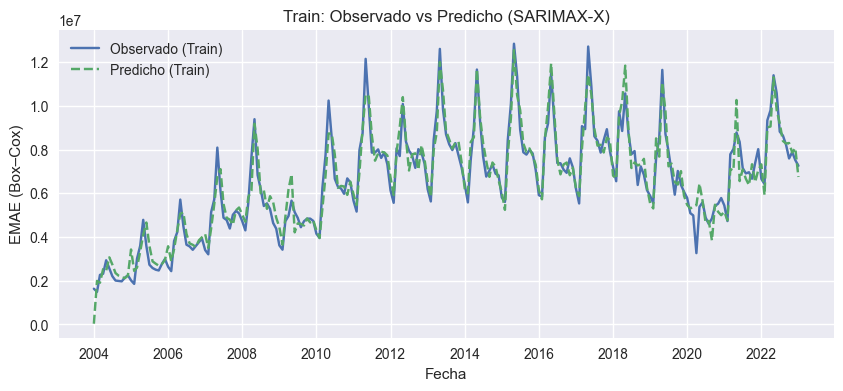

In [108]:
# Predicción in‐sample sobre el Training Set (Box–Cox)
pred_train_bc = results_x_train.predict(
    start=y_train.index[0],
    end=y_train.index[-1],
    exog=X_train
)

# Gráfico Observado vs Predicho (Train)
plt.figure(figsize=(10, 4))
plt.plot(y_train,              label='Observado (Train)')
plt.plot(pred_train_bc, '--',  label='Predicho (Train)')
plt.title("Train: Observado vs Predicho (SARIMAX-X)")
plt.xlabel("Fecha")
plt.ylabel("EMAE (Box–Cox)")
plt.legend()
plt.grid(True)
plt.show()

In [109]:
# Métricas para el modelo SARIMAX‐X entrenado con exógenas
pred_x_test = results_x_train.get_forecast(
    steps=len(y_test),
    exog=X_test
).predicted_mean

print('--- Métricas SARIMAX‐X (Test) ---')
evaluar_metricas(y_test, pred_x_test)
print()

--- Métricas SARIMAX‐X (Test) ---
MSE:  2074669673558.3008
MAE:  1169499.9362
RMSE: 1440371.3665
MAPE: 15.06%



No mejora la capacidad de generalización del modelo

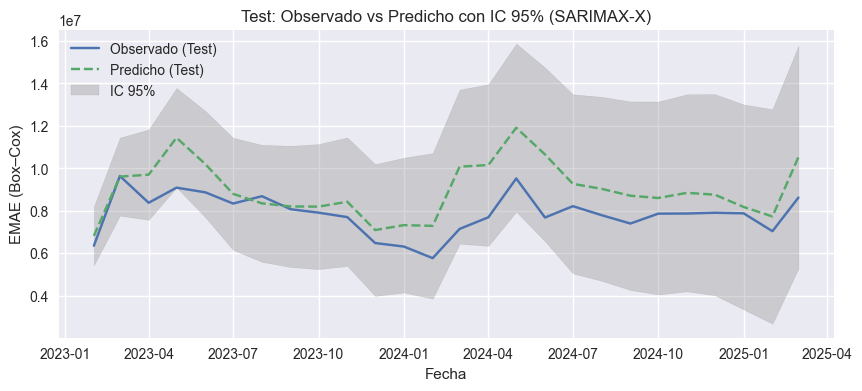

In [110]:
# Forecast sobre el conjunto de test usando el SARIMAX‐X ajustado en train
fc_test        = results_x_train.get_forecast(steps=len(y_test), exog=X_test)
pred_test_bc   = fc_test.predicted_mean
ci_test_bc     = fc_test.conf_int(alpha=0.05)

# Gráfico Observado vs Predicho + IC 95% (Box–Cox)
plt.figure(figsize=(10,4))
plt.plot(y_test.index,      y_test,        label='Observado (Test)')
plt.plot(pred_test_bc.index, pred_test_bc, linestyle='--', label='Predicho (Test)')
plt.fill_between(
    ci_test_bc.index,
    ci_test_bc.iloc[:, 0],
    ci_test_bc.iloc[:, 1],
    color='gray', alpha=0.3,
    label='IC 95%'
)
plt.title("Test: Observado vs Predicho con IC 95% (SARIMAX-X)")
plt.xlabel("Fecha")
plt.ylabel("EMAE (Box–Cox)")
plt.legend()
plt.grid(True)
plt.show()


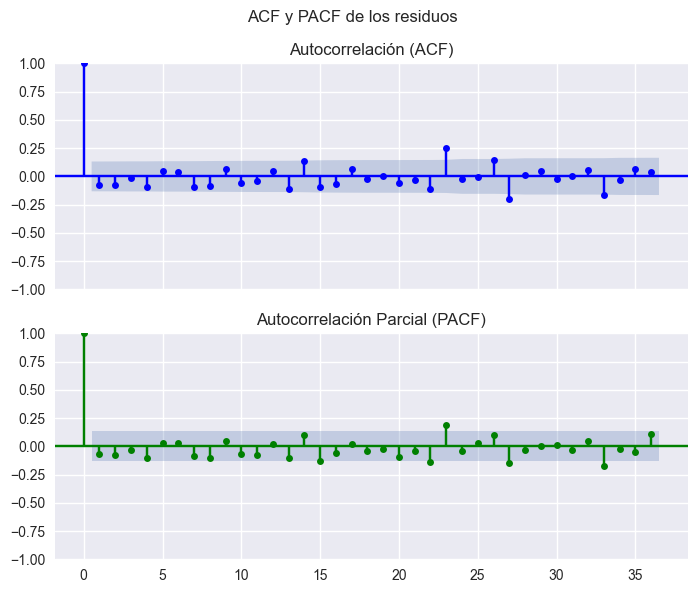

In [123]:
# Residuos del modelo
residuos_x = results_x_train.resid

# Graficamos 
graficar_acf_pacf(residuos_x, n_lags=36, titulo="ACF y PACF de los residuos")

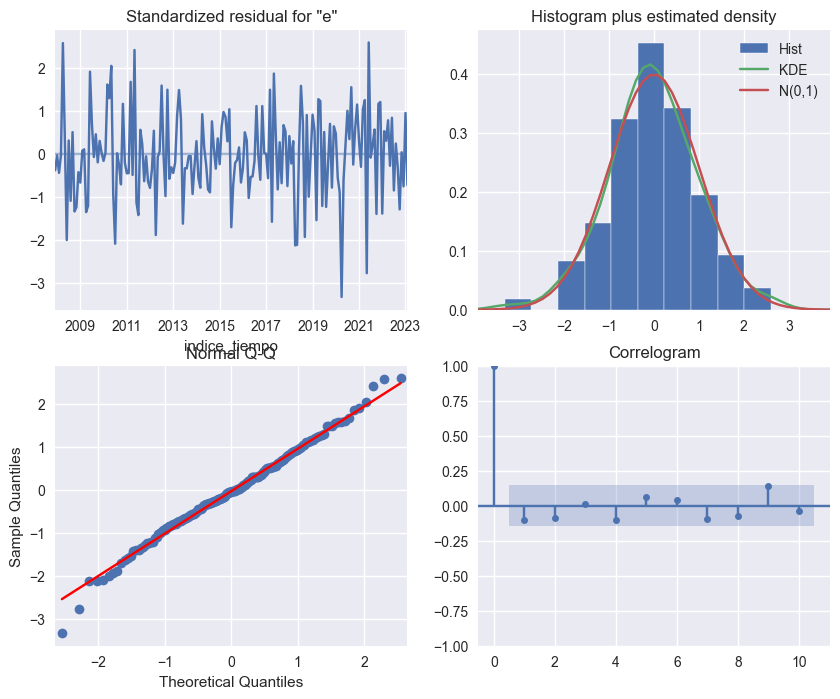

In [124]:
# Análisis de diagnóstico
fig_res_x = results_x_train.plot_diagnostics(figsize=(10, 8))
plt.show()

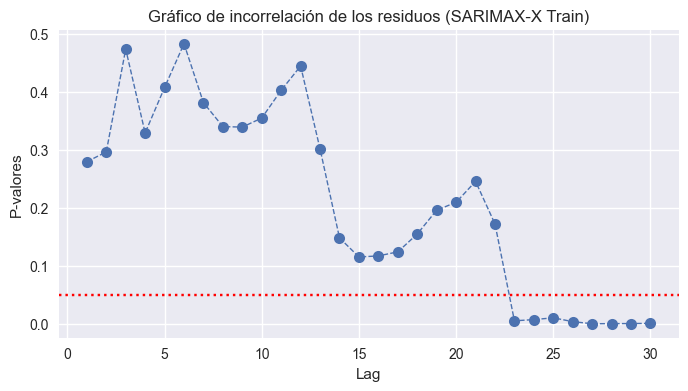

In [125]:
# Test de Ljung–Box y gráfico de p-valores para residuos del SARIMAX-X ajustado en train
lb_test = sm.stats.acorr_ljungbox(results_x_train.resid, lags=30, return_df=True)
plt.figure(figsize=(8,4))
plt.plot(lb_test['lb_pvalue'], marker='o', markersize=8, linestyle='--', linewidth=1)
plt.axhline(0.05, color='red', linestyle=':')
plt.title("Gráfico de incorrelación de los residuos (SARIMAX-X Train)")
plt.xlabel("Lag")
plt.ylabel("P-valores")
plt.grid(True)
plt.show()

---- 
## Extra: Prueba de Hipótesis de HEGY

In [126]:
# Vamos a utilizar la serie con la transformación box cox, porque corroboramos que tiene varianza inestable

emae_boxcox = pd.Series(emae_boxcox, index=df_emae.index, name='emae_boxcox')
print(type(emae_boxcox))   # debe ser <class 'pandas.core.series.Series'>

<class 'pandas.core.series.Series'>


In [127]:
# Diferenciamos 
dy = emae_boxcox.diff().dropna()

In [128]:
# Definimos la serie Box–Cox como Series con índice
y_bc = pd.Series(emae_boxcox, index=df_emae.index, name='y_bc')
dy   = y_bc.diff().dropna()

In [129]:
# 2. Construir los “regresores HEGY” para raíz unitaria en frecuencia cero y estacionales
z1 = y_bc.shift(1)                                        # raíz en 1
z2 = y_bc.shift(1) + y_bc.shift(2)                        # raíz en ω = π
z3 = y_bc.shift(1) - y_bc.shift(2)                        # raíces en ±π/6
z4 = y_bc.shift(11) + y_bc.shift(13)                      # raíces en ±π/3
z5 = y_bc.shift(11) - y_bc.shift(13)                      # raíces en ±π/2

In [130]:
# Rezagos de Δy para “llenar” errores seriales (hasta 12 lags)
lags = {f'dy_lag{i}': dy.shift(i) for i in range(1,13)}

In [131]:
# Montamos DataFrame de regresores y alinear con dy
X_hegy = pd.concat([z1, z2, z3, z4, z5, pd.DataFrame(lags)], axis=1).dropna()
Y_hegy = dy.loc[X_hegy.index]

In [132]:
# Ajustamos la regresión auxiliar
mod_hegy = sm.OLS(Y_hegy, sm.add_constant(X_hegy)).fit()
print(mod_hegy.summary())

                            OLS Regression Results                            
Dep. Variable:                   y_bc   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     38.99
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           1.26e-50
Time:                        14:42:07   Log-Likelihood:                -3600.9
No. Observations:                 242   AIC:                             7230.
Df Residuals:                     228   BIC:                             7279.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.118e+05   1.88e+05      2.729      0.0

In [133]:
# Renombramos cada regresor
z1 = y_bc.shift(1).rename("z1")
z2 = (y_bc.shift(1) + y_bc.shift(2)).rename("z2")
z3 = (y_bc.shift(1) - y_bc.shift(2)).rename("z3")
z4 = (y_bc.shift(11)+ y_bc.shift(13)).rename("z4")
z5 = (y_bc.shift(11)- y_bc.shift(13)).rename("z5")
lags = {f"dy_lag{i}": dy.shift(i) for i in range(1,13)}
X_hegy = pd.concat([z1, z2, z3, z4, z5, pd.DataFrame(lags)], axis=1).dropna()
Y_hegy = dy.loc[X_hegy.index]
X_hegy = sm.add_constant(X_hegy)
mod_hegy = sm.OLS(Y_hegy, X_hegy).fit()
print(mod_hegy.params)   # revisa los nombres

const       511815.566564
z1              -0.040501
z2              -0.062586
z3              -0.015610
z4               0.048637
z5               0.187629
dy_lag1         -0.016037
dy_lag2          0.069464
dy_lag3         -0.081380
dy_lag4         -0.082262
dy_lag5          0.052797
dy_lag6          0.025437
dy_lag7         -0.046856
dy_lag8         -0.062950
dy_lag9         -0.035631
dy_lag10         0.019896
dy_lag11        -0.291260
dy_lag12         0.478927
dtype: float64


In [134]:
# Hacer los F-tests sobre cada conjunto de coeficientes:
#    • Test raíz en 1:    H0: z1 = 0
print(mod_hegy.f_test("z1 = 0"))
#    • Test raíz en π:    H0: z2 = 0
print(mod_hegy.f_test("z2 = 0"))
#    • Test raíces ±π/6:  H0: z3 = 0
print(mod_hegy.f_test("z3 = 0"))
#    • Test raíces ±π/3:  H0: z4 = 0
print(mod_hegy.f_test("z4 = 0"))
#    • Test raíces ±π/2:  H0: z5 = 0
print(mod_hegy.f_test("z5 = 0"))

<F test: F=11.466383108720464, p=0.0008344648560097643, df_denom=228, df_num=1>
<F test: F=18.239306097901096, p=2.8605844407474845e-05, df_denom=228, df_num=1>
<F test: F=0.6390955687873306, p=0.4248705518875693, df_denom=228, df_num=1>
<F test: F=8.470439540535788, p=0.00396729238560169, df_denom=228, df_num=1>
<F test: F=70.7196608036382, p=4.507825982348516e-15, df_denom=228, df_num=1>


In [135]:
def hegy_f_tests(mod_hegy, alpha=0.05):
    """
    Realiza y reporta los F‐tests HEGY para cada raíz unitaria estacional y de tendencia.
    """
    tests = {
        'z1': 'frecuencia cero (tendencia)',
        'z2': 'frecuencia π (semianual)',
        'z3': 'frecuencia ±π/6 (bimestral)',
        'z4': 'frecuencia ±π/3 (cuatrimestral)',
        'z5': 'frecuencia ±π/2 (trimestral)'
    }
    for z, desc in tests.items():
        res = mod_hegy.f_test(f"{z} = 0")
        f_stat = float(res.statistic)
        p_val  = float(res.pvalue)
        print(f"--- Test raíz unitaria en {desc} ---")
        print(f"H₀: {z} = 0   H₁: {z} ≠ 0")
        print(f"F = {f_stat:.4f}, p = {p_val:.4f}")
        if p_val < alpha:
            print(f"→ p < {alpha}: rechazamos H₀ ⇒ ❌ no hay raíz unitaria en {desc}.")
        else:
            print(f"→ p ≥ {alpha}: no rechazamos H₀ ⇒ ✅ sí hay raíz unitaria en {desc}.")
        print()

hegy_f_tests(mod_hegy, alpha=0.05)

--- Test raíz unitaria en frecuencia cero (tendencia) ---
H₀: z1 = 0   H₁: z1 ≠ 0
F = 11.4664, p = 0.0008
→ p < 0.05: rechazamos H₀ ⇒ ❌ no hay raíz unitaria en frecuencia cero (tendencia).

--- Test raíz unitaria en frecuencia π (semianual) ---
H₀: z2 = 0   H₁: z2 ≠ 0
F = 18.2393, p = 0.0000
→ p < 0.05: rechazamos H₀ ⇒ ❌ no hay raíz unitaria en frecuencia π (semianual).

--- Test raíz unitaria en frecuencia ±π/6 (bimestral) ---
H₀: z3 = 0   H₁: z3 ≠ 0
F = 0.6391, p = 0.4249
→ p ≥ 0.05: no rechazamos H₀ ⇒ ✅ sí hay raíz unitaria en frecuencia ±π/6 (bimestral).

--- Test raíz unitaria en frecuencia ±π/3 (cuatrimestral) ---
H₀: z4 = 0   H₁: z4 ≠ 0
F = 8.4704, p = 0.0040
→ p < 0.05: rechazamos H₀ ⇒ ❌ no hay raíz unitaria en frecuencia ±π/3 (cuatrimestral).

--- Test raíz unitaria en frecuencia ±π/2 (trimestral) ---
H₀: z5 = 0   H₁: z5 ≠ 0
F = 70.7197, p = 0.0000
→ p < 0.05: rechazamos H₀ ⇒ ❌ no hay raíz unitaria en frecuencia ±π/2 (trimestral).



----
## Fin del código!